# CE-40717: Machine Learning

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

In [6]:
#Read train and test data
import torchvision.datasets as ds
import numpy as np
np.seterr(all='raise')

data_train = np.array(ds.MNIST(root="./data", train=True, download=False).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=False).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=False).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=False).targets)

In [7]:
#Define epsilon value . we will use this to prevent "Division by zero" error 
EPS = np.finfo(float).eps

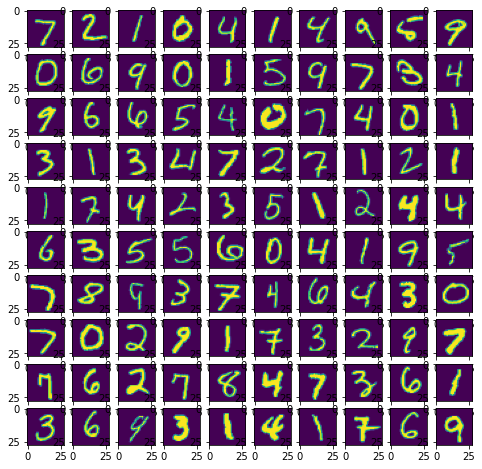

In [8]:
#Look at data
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10,10, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(data_test[i])

In [9]:
#change each image from 2d array to corresponding 1d array 
data_train.shape = (data_train.shape[0] , data_train.shape[1] * data_train.shape[2])
data_test.shape = (data_test.shape[0] , data_test.shape[1] * data_test.shape[2])

#normalizes values to the range [0 , 1]
data_train = data_train / 255
data_test = data_test / 255

### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [10]:
class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions):
        self.w1 = np.random.normal(size=(in_dimensions, hidden_dimensions)) / np.sqrt(in_dimensions)
        self.b1 = np.random.normal(size=(1,hidden_dimensions)) / np.sqrt(in_dimensions)
        self.w2 = np.random.normal(size=(hidden_dimensions,out_dimensions)) / np.sqrt(in_dimensions)
        self.b2 = np.random.normal(size=(1,out_dimensions)) / np.sqrt(in_dimensions)

    # Linear activation function
    def linear_forward(self , s):
        return s
    # Gradient of linear activation function
    def linear_backward(self , x):
        return 1

    # Softmax activation function    
    def softmax_forward(self , s):
        return np.exp(s - s.max()) / np.exp(s - s.max()).sum()
    
    # Gradient of softmax activation function    
    def softmax_backward(self , out):
        return out - y
        
    def forward(self, x):
        x = x[:, np.newaxis] #input
        
        #Input Layer
        self.h1_forward = x

        h1_tot = np.concatenate(([[1]],self.h1_forward))
        w1_tot = np.concatenate((self.b1,self.w1))
        
        #Hidden Layer
        self.s2_forward = np.matmul(np.transpose(w1_tot) , h1_tot)
        self.h2_forward = self.linear_forward(self.s2_forward)
    
        h2_tot = np.concatenate(([[1]],self.h2_forward))
        w2_tot = np.concatenate((self.b2,self.w2))
        
        #Output Layer
        self.s3_forward = np.matmul(np.transpose(w2_tot) , h2_tot)
        self.h3_forward = self.softmax_forward(self.s3_forward)
        
    def backward(self, loss, y):
        #Output Layer
        self.w3_backward = self.softmax_backward(self.h3_forward)
        
        #Hidden Layer
        self.w2_backward = np.multiply(self.linear_backward(self.h2_forward) , np.matmul(self.w2 , self.w3_backward))
   
    def step(self, lr, lam):
        # w2
        self.w2 = (1 - lam) * self.w2 - lr * np.matmul(self.h2_forward , np.transpose(self.w3_backward))
        
        #w1
        self.w1 = (1 - lam) * self.w1 - lr * np.matmul(self.h1_forward , np.transpose(self.w2_backward))
        

### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [11]:
n_epochs = 2
lr = 0.01
k =10
in_dim = 28 * 28
hidden_dim = 5
out_dim =  10
fold_len = int(data_train.shape[0]/k)
lambdas = [0.001 , 0.0005 , 0.0001]
best_lambda = lambdas[-1]
best_acc = 0

for l in lambdas:
    acc = 0
    loss = 0
    for j in range(k):
        model = MLP(in_dim, hidden_dim, out_dim)

        #Split data to train and test sets        
        all_indices = list(range(len(data_train)))
        train_indices = all_indices[0:j * fold_len] + all_indices[(j+1) * fold_len:]
        val_indices = all_indices[j * fold_len : (j+1) * fold_len]
        
        fold_train_set = np.take(data_train, train_indices, 0)
        fold_train_target = np.take(target_train, train_indices, 0)
        
        val_set = np.take(data_train, val_indices, 0)
        val_target = np.take(target_train, val_indices, 0)
        
        for e in range(n_epochs):
            for index in range(len(fold_train_set)):                
                
                #convert target to one-hot vector
                y = np.zeros((10, 1))
                y[fold_train_target[index]] = 1
                
                model.forward(fold_train_set[index])
                model.backward(0 , y)
                model.step(lr , l)
            
        # Test the model on the current validation data
        fold_acc = 0
        fold_loss = 0

        for index in range(len(val_set)):
            
            #convert target to one-hot vector
            y = np.zeros((10, 1))
            y[val_target[index]] = 1
            
            model.forward(val_set[index])
            
            fold_loss = fold_loss - np.log(model.h3_forward[val_target[index]] + EPS)
            
            ypred = model.h3_forward.argmax()
            if ypred == val_target[index]:
                fold_acc = fold_acc + 1
        
        fold_acc = fold_acc / len(val_set)
        acc = acc + fold_acc
        loss = loss + (fold_loss + l / 2 * ((model.w1**2).sum() + (model.w2**2).sum())) / len(val_set)
    
    
    loss = loss / k
    acc = acc / k
    print("Lambda:", l)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    print()
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is",best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 0.001
Loss: 0.9691 Accuracy: 0.7341

Lambda: 0.0005
Loss: 0.7650 Accuracy: 0.7655

Lambda: 0.0001
Loss: 0.5672 Accuracy: 0.8184

Best lambda is 0.0001 with 0.8184 accuracy


### Part3:
Train a final model using the best lambda on all the training data

In [12]:
in_dim = 28 * 28
hidden_dim = 5
out_dim =  10

n_epochs = 5
lr = 0.01

train_accs = [] # a list that keeps track of accuracy value during training
train_losss = [] # a list that keeps track of loss value during training

model = MLP(in_dim, hidden_dim, out_dim)

for e in range(n_epochs):
    epoch_acc = 0
    epoch_loss = 0
    for index in range(len(data_train)):                
        
        #convert target to one-hot vector
        y = np.zeros((10, 1))
        y[target_train[index]] = 1

        model.forward(data_train[index])
        model.backward(0 , y)
        model.step(lr , best_lambda)

        ypred = model.h3_forward.argmax()
        if ypred == target_train[index]:
            epoch_acc = epoch_acc + 1

        epoch_loss = epoch_loss - np.log(model.h3_forward[target_train[index]] + EPS)[0]
    
    epoch_loss = epoch_loss + l / 2 * ((model.w1**2).sum() + (model.w2**2).sum())
    epoch_loss = epoch_loss / len(data_train)

    train_accs.append(epoch_acc / len(data_train))
    train_losss.append(epoch_loss)

### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

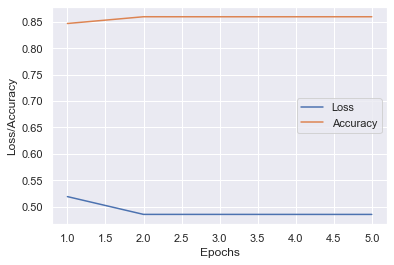

In [13]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame({"Epochs" : np.arange(1 , 6) , "Loss" : train_losss , "Accuracy" : train_accs})

sns.set_theme()
sns.lineplot(x=data["Epochs"] , y = data["Loss"])
sns.lineplot(x=data["Epochs"] , y = data["Accuracy"])
plt.ylabel("Loss/Accuracy")
plt.legend(labels=['Loss', 'Accuracy'])

Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [14]:
acc = 0

for index in range(len(data_test)):

    #feed test example to model
    model.forward(data_test[index])

    y = target_test[index]
    
    ypred = model.h3_forward.argmax()
    if ypred == y:
        acc = acc + 1

acc = acc / len(data_test)
acc = acc * 100
print("Accuracy On Test Set Is : " + str(acc) + "%")

Accuracy On Test Set Is : 82.25%


Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.


In [15]:
class MLP_3L:
    def __init__(self, in_dimensions, hidden1_dimensions , hidden2_dimensions, out_dimensions):
        self.w1 = np.random.normal(size=(in_dimensions, hidden1_dimensions)) / in_dimensions
        self.b1 = np.random.normal(size=(1,hidden1_dimensions)) / in_dimensions
        self.w2 = np.random.normal(size=(hidden1_dimensions,hidden2_dimensions)) / in_dimensions
        self.b2 = np.random.normal(size=(1,hidden2_dimensions)) / in_dimensions
        self.w3 = np.random.normal(size=(hidden2_dimensions, out_dimensions)) / in_dimensions
        self.b3 = np.random.normal(size=(1,out_dimensions)) / in_dimensions
    
    # Relu activation function
    def relu_forward(self , s):
        return np.maximum(s , 0)
    
    # Gradient of relu activation function
    def relu_backward(self , x):
        return (x > 0).astype('float64')
    
    def softmax_forward(self , s):
        return np.exp(s - s.max()) / np.exp(s - s.max()).sum()
    
    def softmax_backward(self , out):
        return out - y
    
    
    def forward(self, x):
        x = x[:, np.newaxis] #input
        
        #Input Layer
        self.h1_forward = x

        h1_tot = np.concatenate(([[1]],self.h1_forward))
        w1_tot = np.concatenate((self.b1,self.w1))
        
        #Hidden Layer 1
        self.s2_forward = np.matmul(np.transpose(w1_tot) , h1_tot)
        self.h2_forward = self.relu_forward(self.s2_forward)
    
        h2_tot = np.concatenate(([[1]],self.h2_forward))
        w2_tot = np.concatenate((self.b2,self.w2))
        
        #Hidden Layer 2
        self.s3_forward = np.matmul(np.transpose(w2_tot) , h2_tot)
        self.h3_forward = self.relu_forward(self.s3_forward)
    
        h3_tot = np.concatenate(([[1]],self.h3_forward))
        w3_tot = np.concatenate((self.b3,self.w3))
        
        #Output Layer
        self.s4_forward = np.matmul(np.transpose(w3_tot) , h3_tot)
        self.h4_forward = self.softmax_forward(self.s4_forward)
        
    def backward(self, loss, y):
        #Output Layer
        self.w4_backward = self.softmax_backward(self.h4_forward)
        
        #Hidden Layer 2
        self.w3_backward = np.multiply(self.relu_backward(self.h3_forward) , np.matmul(self.w3 , self.w4_backward))
   
        #Hidden Layer 1
        self.w2_backward = np.multiply(self.relu_backward(self.h2_forward) , np.matmul(self.w2 , self.w3_backward))

    def step(self, lr, lam):
        # w3
        self.w3 = (1 - lam) * self.w3 - lr * np.matmul(self.h3_forward , np.transpose(self.w4_backward))

        # w2
        self.w2 = (1 - lam) * self.w2 - lr * np.matmul(self.h2_forward , np.transpose(self.w3_backward))
        
        #w1
        self.w1 = (1 - lam) * self.w1 - lr * np.matmul(self.h1_forward , np.transpose(self.w2_backward))
        

In [16]:
in_dim = 28 * 28
hidden_dim_1 = 100
hidden_dim_2 = 200
out_dim =  10

n_epochs = 10
lr = 0.01

train_accs = []
train_losss = []
lam = 0

#Create instance of new model with above configurations
model = MLP_3L(in_dim, hidden_dim_1 , hidden_dim_2 , out_dim)

for e in range(n_epochs):
    epoch_acc = 0
    epoch_loss = 0
    for index in range(len(data_train)):                

        y = np.zeros((10, 1))
        y[target_train[index]] = 1

        model.forward(data_train[index])
        model.backward(0 , y)
        model.step(lr , lam)

        ypred = model.h4_forward.argmax()

        if ypred == target_train[index]:
            epoch_acc = epoch_acc + 1

        epoch_loss = epoch_loss - np.log(model.h4_forward[target_train[index]] + EPS)[0]

    epoch_loss = epoch_loss + lam / 2 * ((model.w1**2).sum() + (model.w2).sum() + (model.w3).sum())
    epoch_loss = epoch_loss / len(data_train)


    train_accs.append(epoch_acc / len(data_train))
    train_losss.append(epoch_loss)

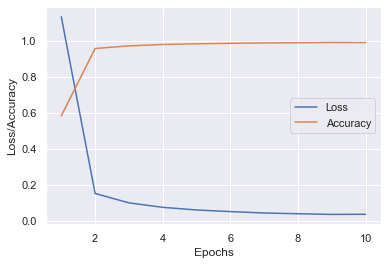

In [17]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({"Epochs" : np.arange(1 , 11) , "Loss" : train_losss , "Accuracy" : train_accs})
sns.lineplot(x=data["Epochs"] , y = data["Loss"])
sns.lineplot(x=data["Epochs"] , y = data["Accuracy"])
plt.ylabel("Loss/Accuracy")
plt.legend(labels=['Loss', 'Accuracy'])

In [18]:
acc = 0

for index in range(len(data_test)):

    # Feed data to the model
    model.forward(data_test[index])

    y = target_test[index]

    ypred = model.h4_forward.argmax()
    if ypred == y:
        acc = acc + 1

acc = acc / len(data_test)
acc = acc * 100
print("Accuracy On Test Set Is : " + str(acc) + "%")

Accuracy On Test Set Is : 97.11%
